In [1]:
# loading a dataset from torchvision datasets
from torchvision import datasets, transforms
import torch

#
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
root = 'datasets',
train = True,
transform = train_transforms,
download = True,
)
test_dataset = datasets.MNIST(
root = 'datasets',
train = False,
transform = test_transforms,
download=True,
)

# break train data into train, validation
train_len = int(len(train_dataset)*.80)
valid_len = len(train_dataset) - train_len

print(f"initial train set size: {len(train_dataset)}")
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_len, valid_len])
print(f"final train set size: {len(train_dataset)}")
print(f"final valid set size: {len(validation_dataset)}")


train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=32,
                                          shuffle=True)

validation_dataloader = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=32,
                                          shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          shuffle=True)

images, _ = next(iter(train_dataloader))
print(f"batch size train: {images.shape}")
images, _ = next(iter(validation_dataloader))
print(f"batch size valid: {images.shape}")
images, _ = next(iter(test_dataloader))
print(f"batch size test: {images.shape}")


initial train set size: 60000
final train set size: 48000
final valid set size: 12000
batch size train: torch.Size([32, 1, 28, 28])
batch size valid: torch.Size([32, 1, 28, 28])
batch size test: torch.Size([32, 1, 28, 28])


In [2]:
# if you are loading images from a local folder you can do, where the images are individual jpg files
# # Pass transforms in here, then run the next cell to see how the transforms look
# train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
# test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
#
# trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

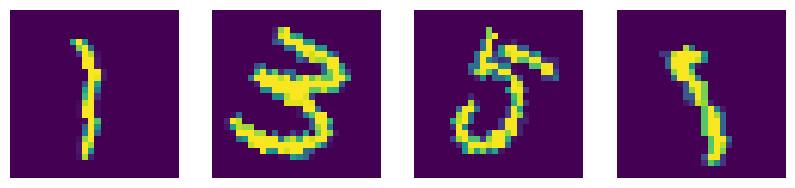

In [3]:
# visualize some images
import matplotlib.pyplot as plt
import helper
images, labels = next(iter(train_dataloader))

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)


In [129]:
# now define CNN model
import torch.nn as nn

class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.cl1 = nn.Conv2d(
            in_channels=1,
            out_channels=8,
            kernel_size=2,
            stride=1,
            padding=1)

        self.cl2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=2,
            stride=1,
            padding=1)

        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(.1)
        self.fc1 = nn.Linear(784, 10)
        self.logsoft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.maxpool(self.cl1(x)))
        x = self.dropout(x)
        x = self.relu(self.maxpool(self.cl2(x)))
        x = self.dropout(x)

        # flatten before feeding to linear layer
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.logsoft(x)
        return x


# try a forward pass to make sure everything looks OK
model = MyCNN()
print(model)

images, labels = next(iter(train_dataloader))
model(images).shape


MyCNN(
  (cl1): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (cl2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (logsoft): LogSoftmax(dim=1)
)


torch.Size([32, 10])

In [130]:
# now lets train
optimizer = torch.optim.Adam(model.parameters(), lr=.003)
criteria = nn.NLLLoss()

epochs = 10

def accuracy(model, criteria, dataset):

    running_loss = 0
    running_accuracy = 0
    for idx, (images, labels) in enumerate(dataset):
        images = images.to("mps")
        labels = labels.to("mps")
        model.eval()
        log_soft = model.forward(images)
        loss = criteria(log_soft, labels)
        running_loss += loss.item()
        _,preds = torch.exp(log_soft).topk(1)
        equals = labels.squeeze()==preds.squeeze()
        running_accuracy += torch.mean(equals.to(torch.float32)).item()
        model.train()

    avg_acc = round(running_accuracy/len(dataset),3)
    avg_los = round(running_loss/len(dataset),3)

    return avg_acc, avg_los

for e in range(1, epochs+1):

    running_loss = 0

    for idx, (images, labels) in enumerate(train_dataloader):

        # use GPU
        torch.device("mps")
        model.to("mps")
        images = images.to("mps")
        labels = labels.to("mps")

        # clean gradients
        optimizer.zero_grad()
        #forward
        log_soft = model.forward(images)
        # loss
        loss = criteria(log_soft, labels)
        running_loss+= loss.item()
        # backward
        loss.backward()
        # gradient step
        optimizer.step()

        #  evaluate
        if idx%500==0:
            train_loss = round(running_loss/(idx+1),3)
            acc, loss_val = accuracy(model, criteria, validation_dataloader)
            print(f"train loss: {train_loss} val loss: {loss_val} val acc: {acc}")



train loss: 2.399 val loss: 2.458 val acc: 0.082
train loss: 0.971 val loss: 0.539 val acc: 0.828
train loss: 0.769 val loss: 0.448 val acc: 0.854
train loss: 0.339 val loss: 0.397 val acc: 0.875
train loss: 0.463 val loss: 0.404 val acc: 0.869
train loss: 0.454 val loss: 0.369 val acc: 0.877
train loss: 0.686 val loss: 0.349 val acc: 0.885
train loss: 0.413 val loss: 0.36 val acc: 0.882
train loss: 0.416 val loss: 0.348 val acc: 0.885
train loss: 0.565 val loss: 0.332 val acc: 0.893
train loss: 0.404 val loss: 0.33 val acc: 0.89
train loss: 0.405 val loss: 0.332 val acc: 0.891
train loss: 0.537 val loss: 0.329 val acc: 0.889
train loss: 0.401 val loss: 0.339 val acc: 0.887
train loss: 0.398 val loss: 0.334 val acc: 0.892
train loss: 0.418 val loss: 0.322 val acc: 0.894
train loss: 0.383 val loss: 0.34 val acc: 0.89
train loss: 0.388 val loss: 0.311 val acc: 0.898
train loss: 0.517 val loss: 0.331 val acc: 0.892
train loss: 0.381 val loss: 0.321 val acc: 0.895
train loss: 0.384 val los